El numero de discos debe ser un entero


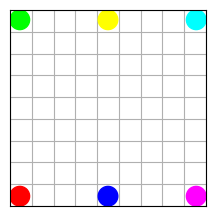

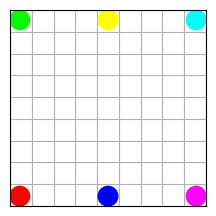

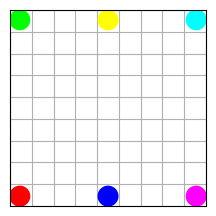

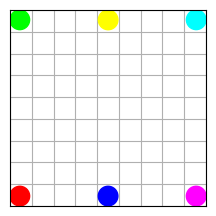

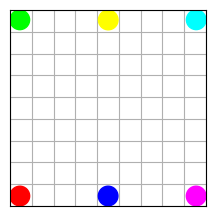

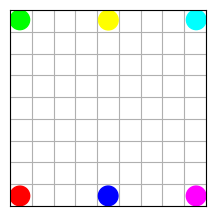

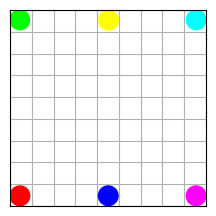

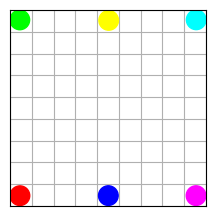

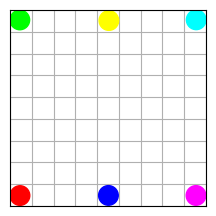

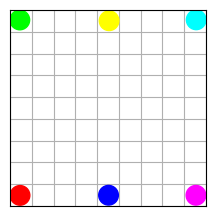

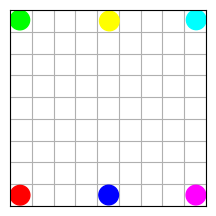

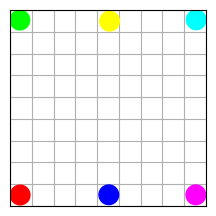

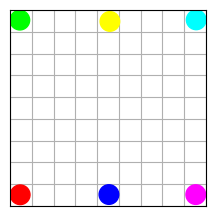

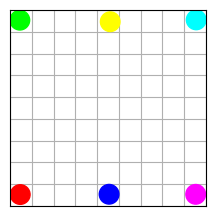

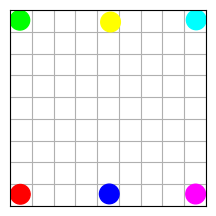

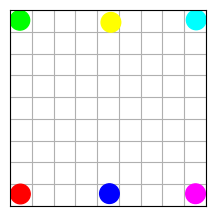

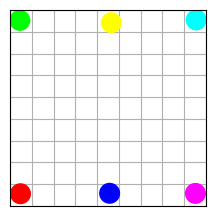

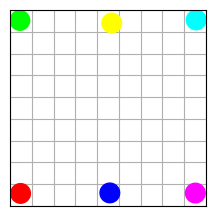

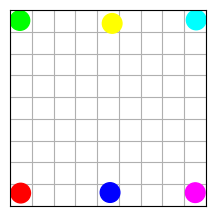

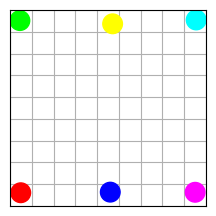

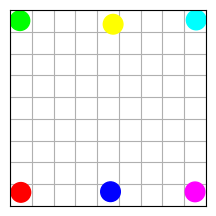

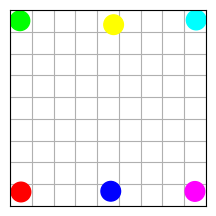

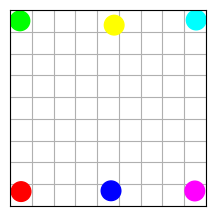

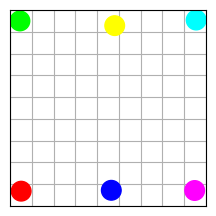

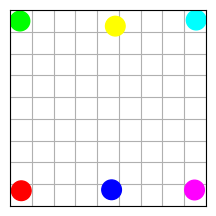

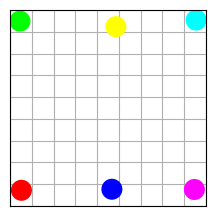

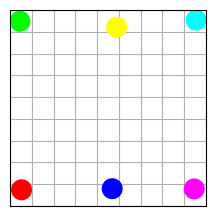

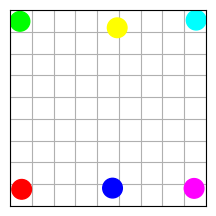

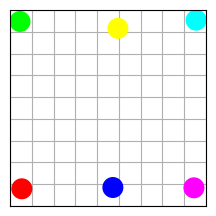

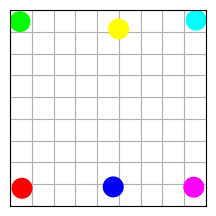

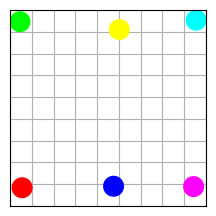

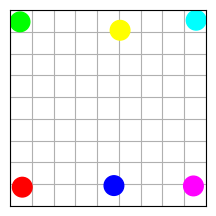

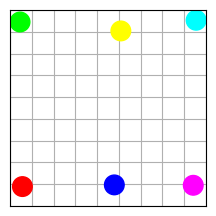

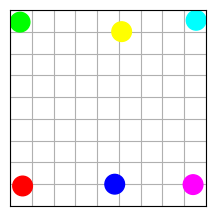

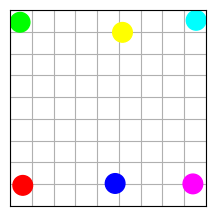

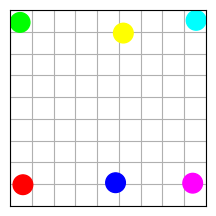

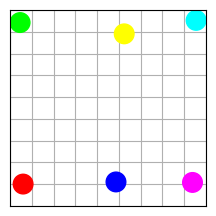

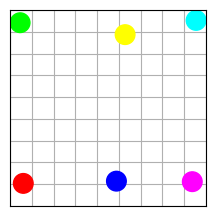

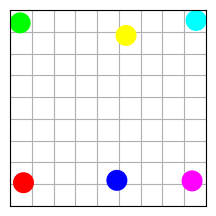

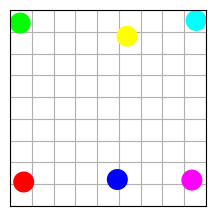

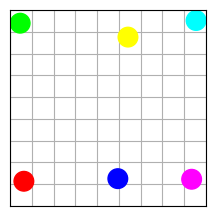

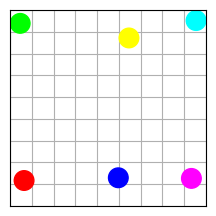

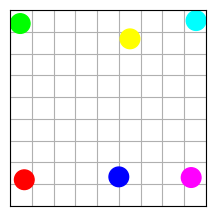

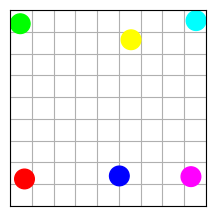

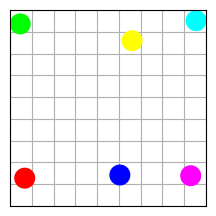

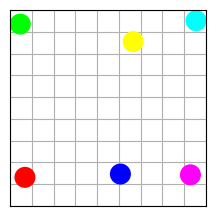

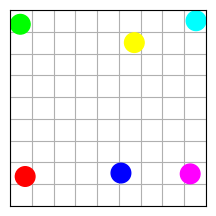

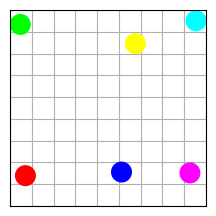

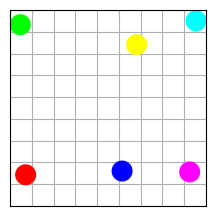

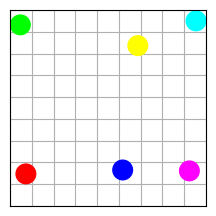

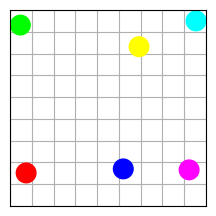

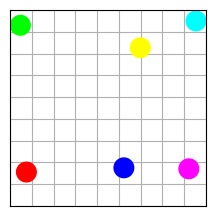

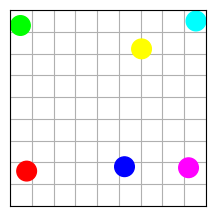

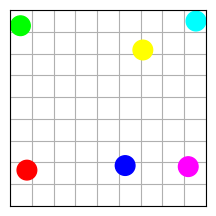

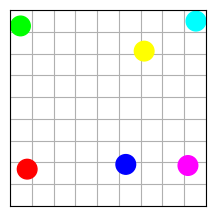

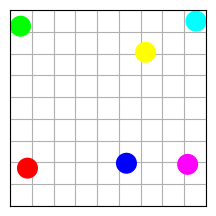

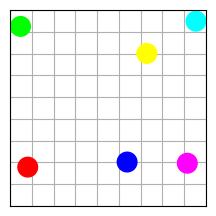

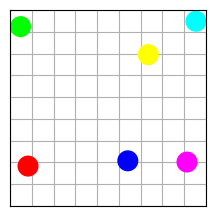

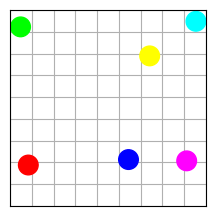

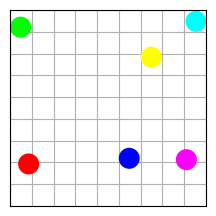

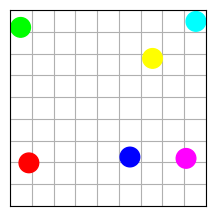

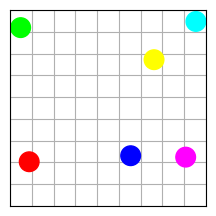

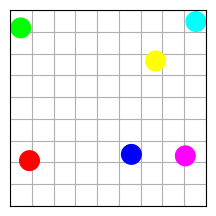

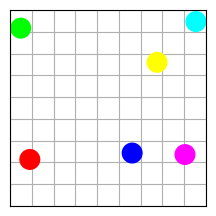

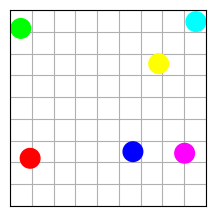

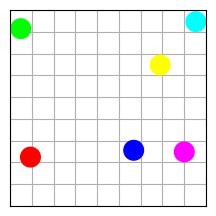

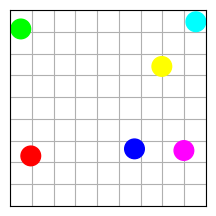

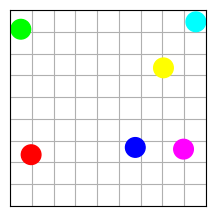

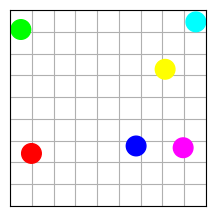

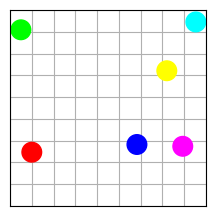

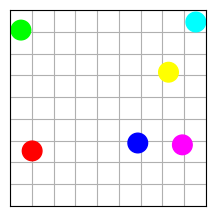

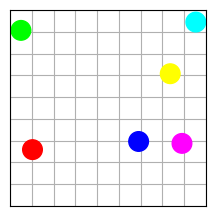

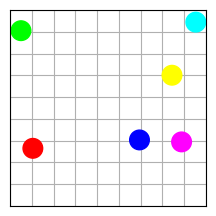

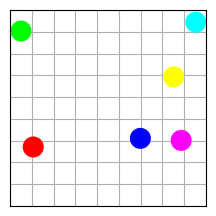

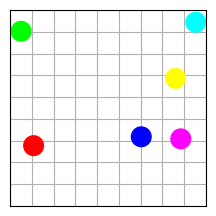

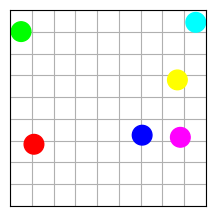

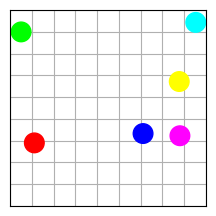

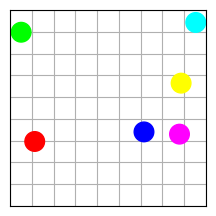

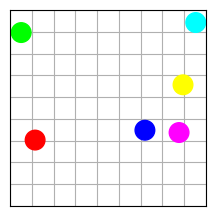

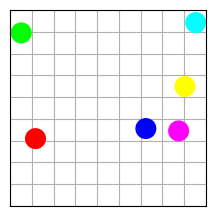

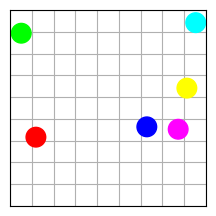

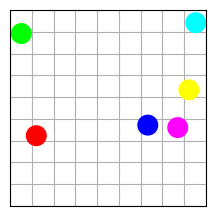

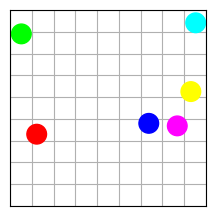

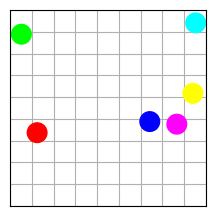

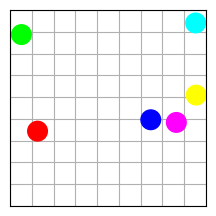

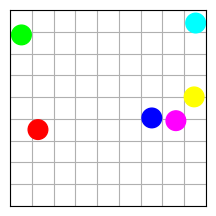

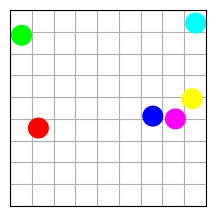

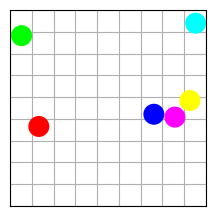

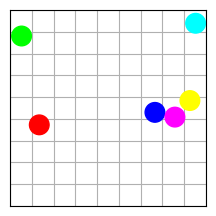

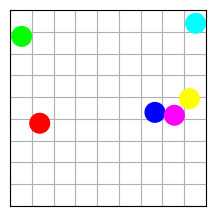

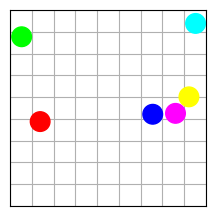

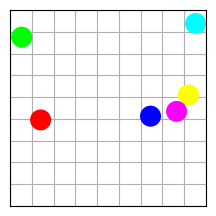

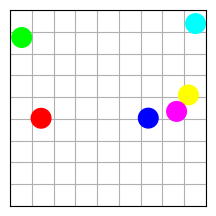

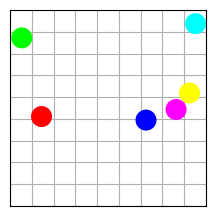

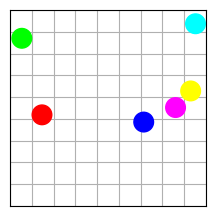

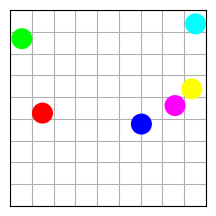

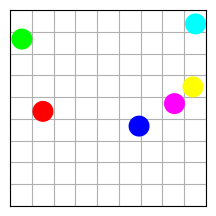

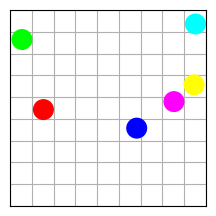

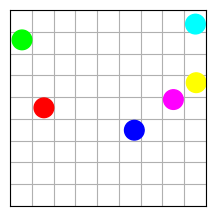

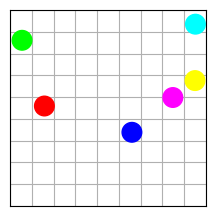

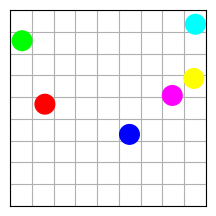

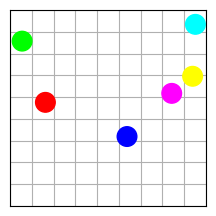

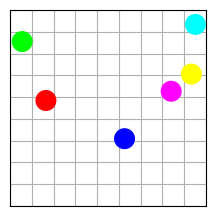

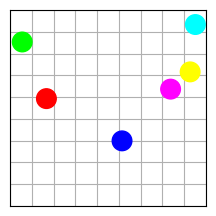

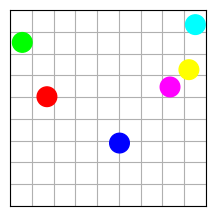

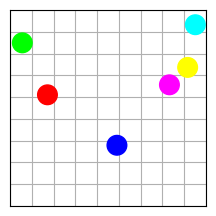

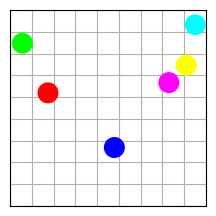

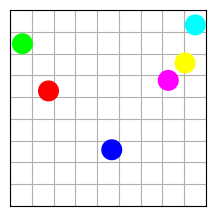

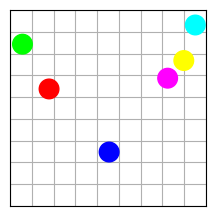

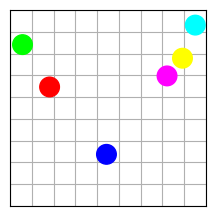

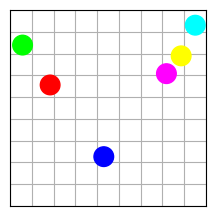

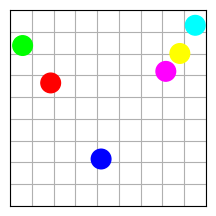

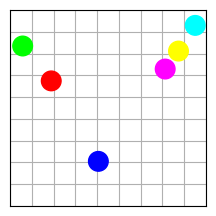

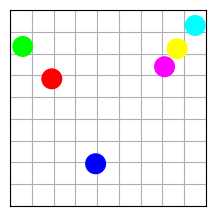

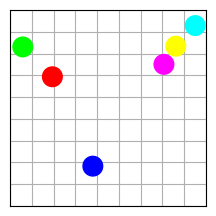

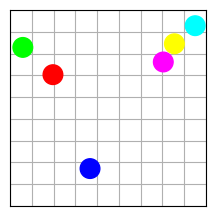

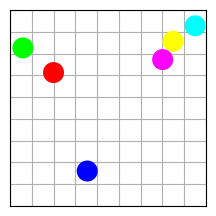

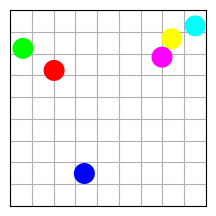

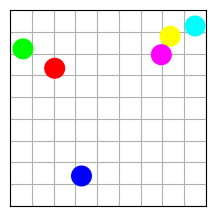

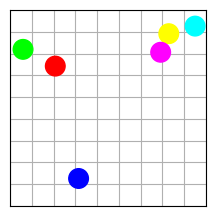

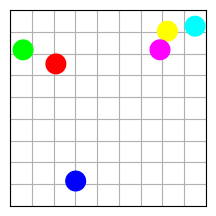

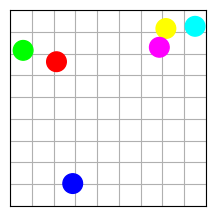

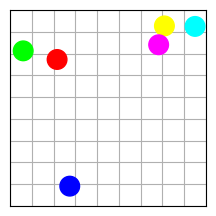

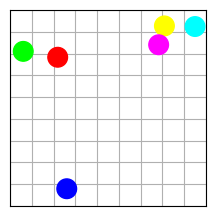

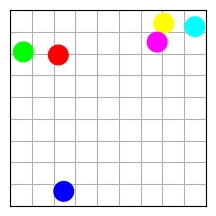

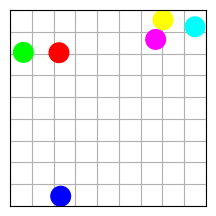

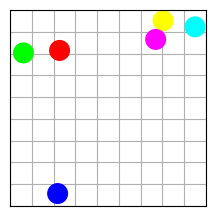

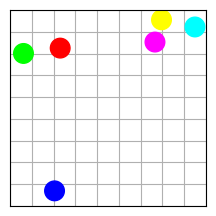

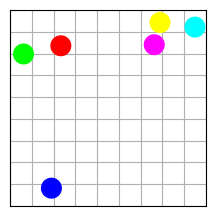

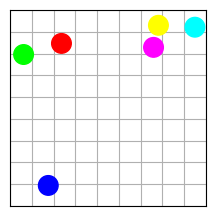

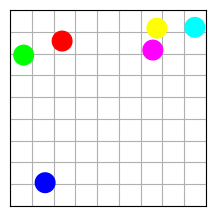

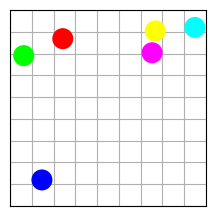

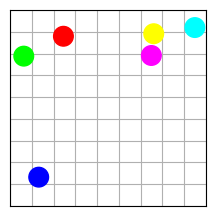

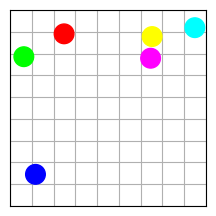

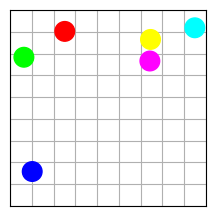

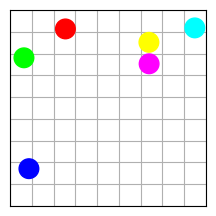

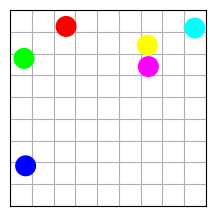

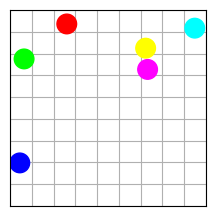

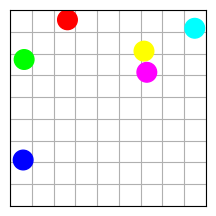

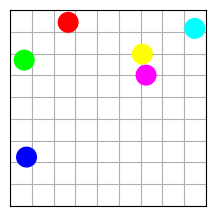

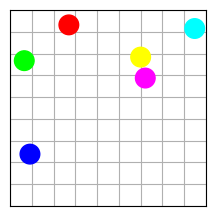

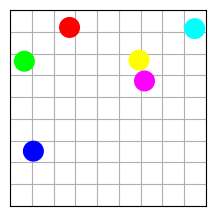

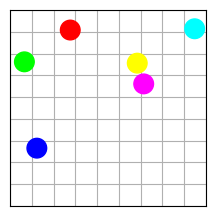

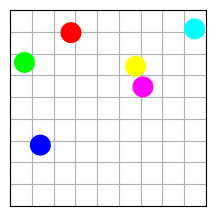

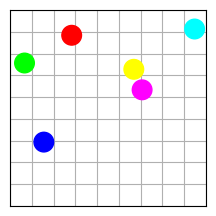

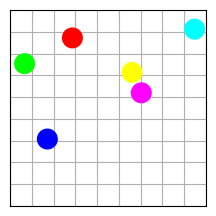

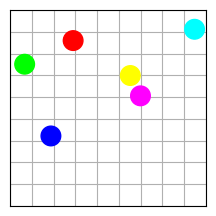

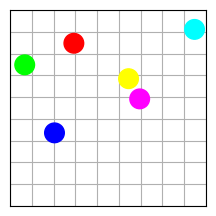

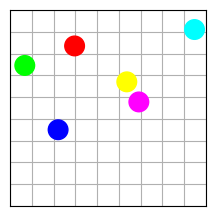

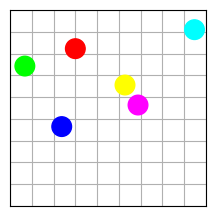

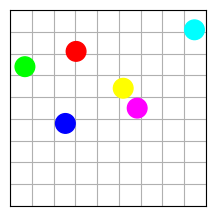

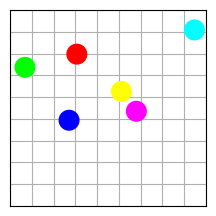

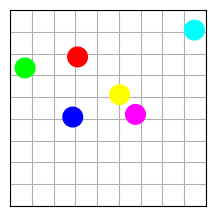

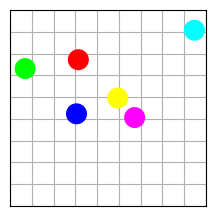

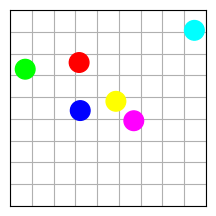

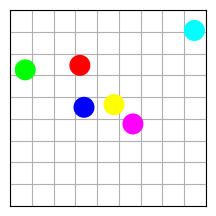

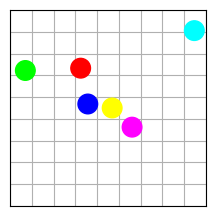

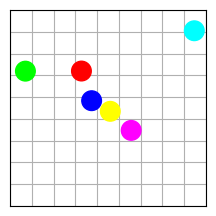

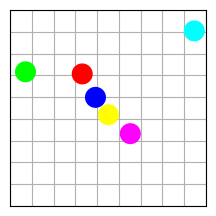

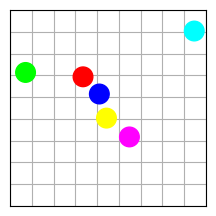

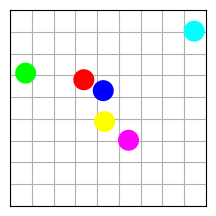

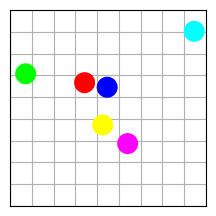

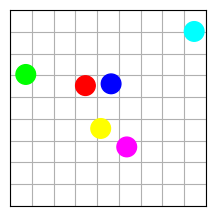

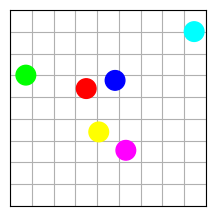

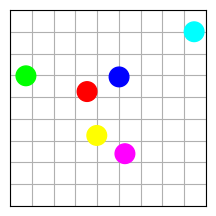

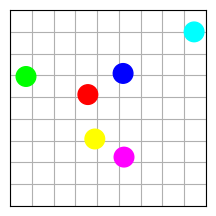

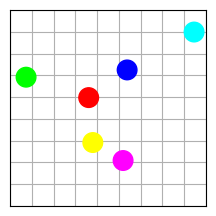

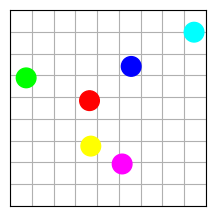

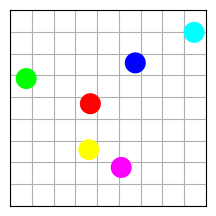

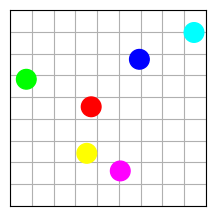

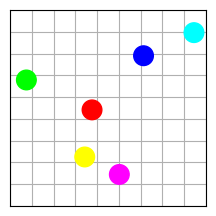

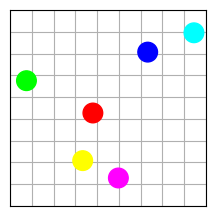

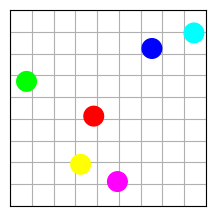

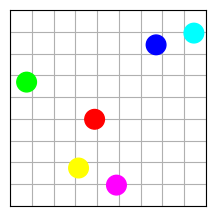

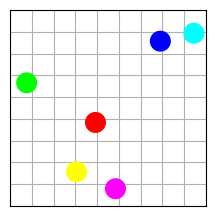

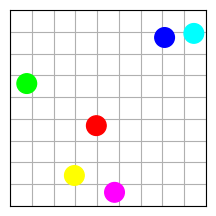

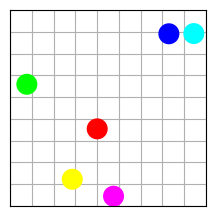

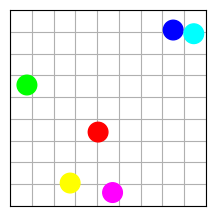

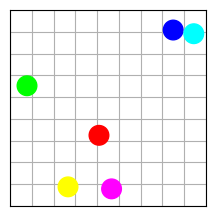

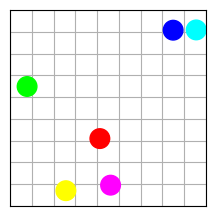

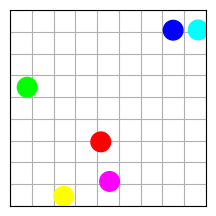

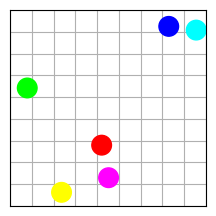

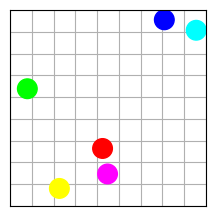

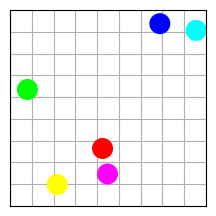

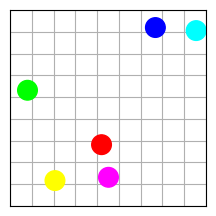

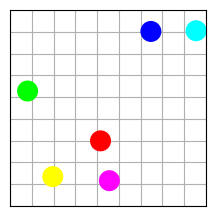

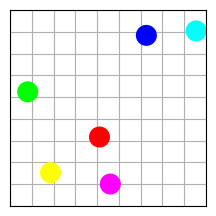

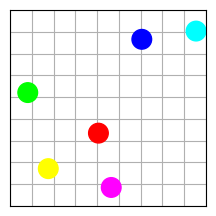

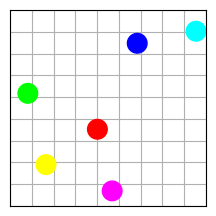

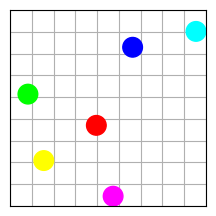

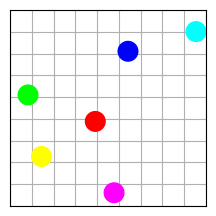

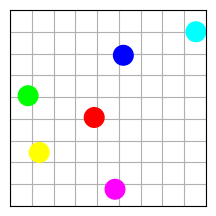

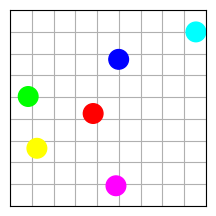

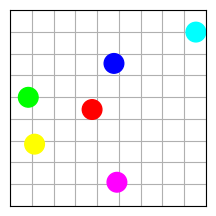

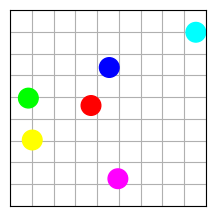

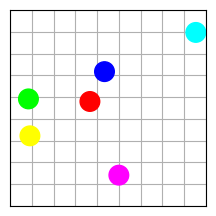

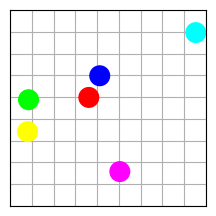

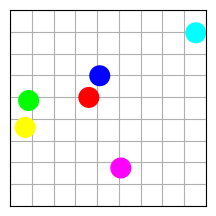

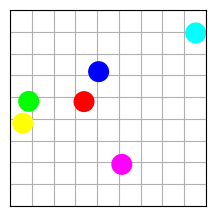

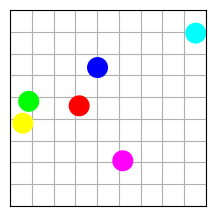

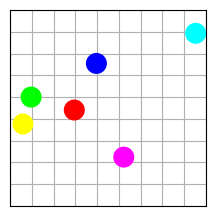

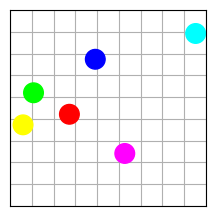

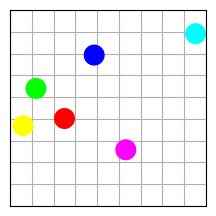

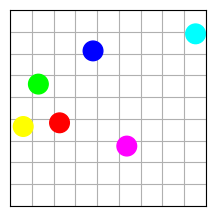

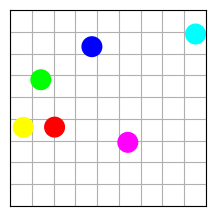

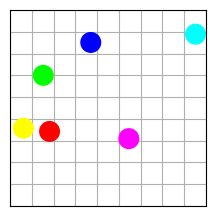

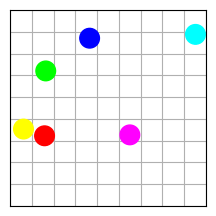

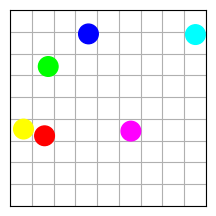

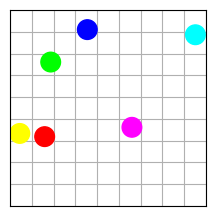

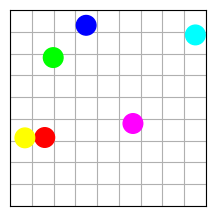

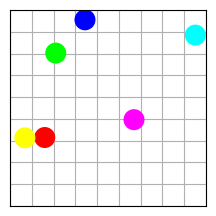

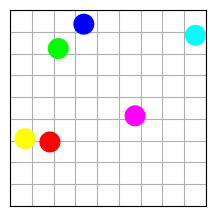

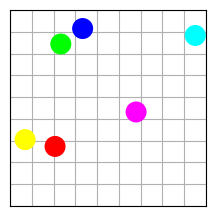

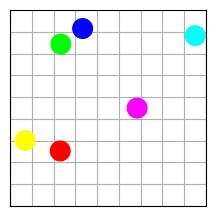

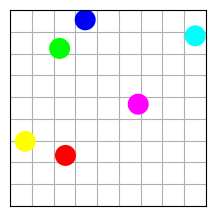

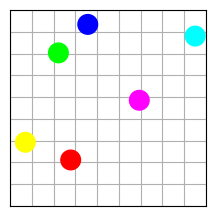

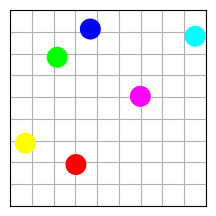

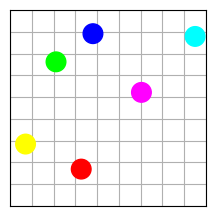

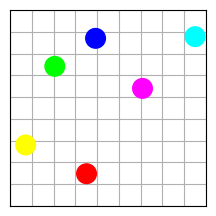

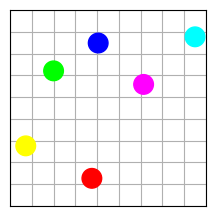

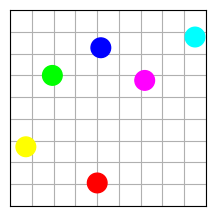

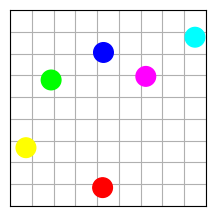

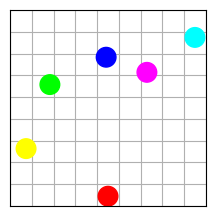

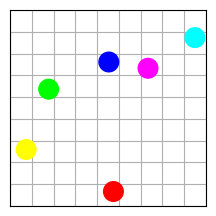

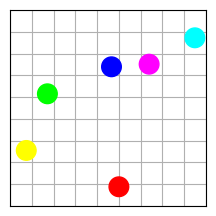

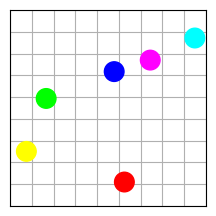

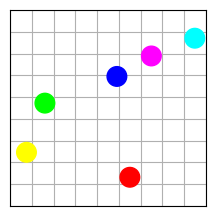

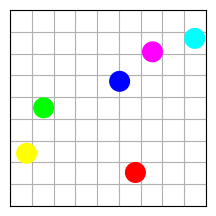

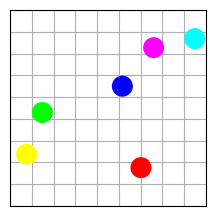

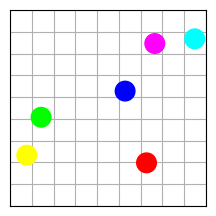

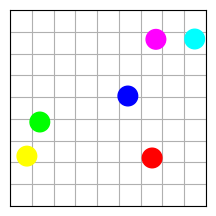

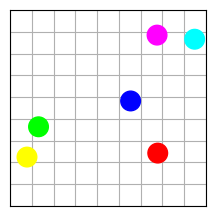

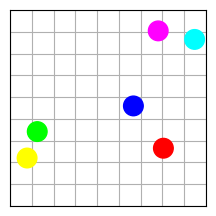

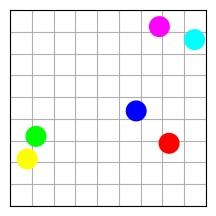

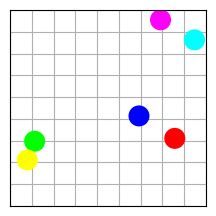

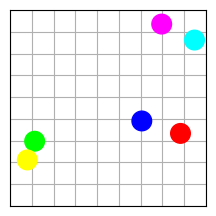

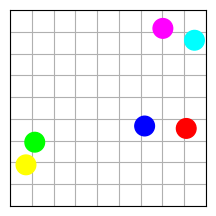

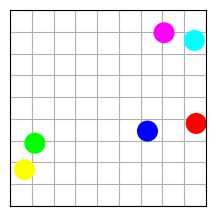

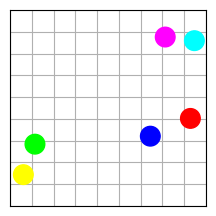

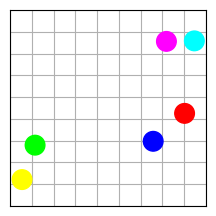

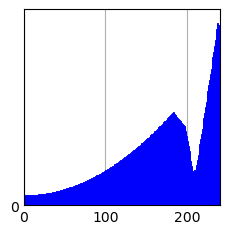

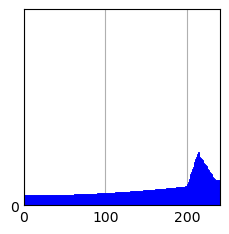

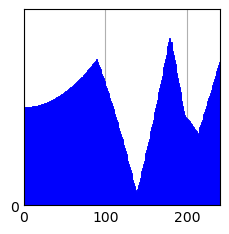

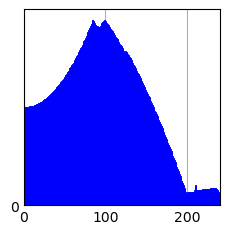

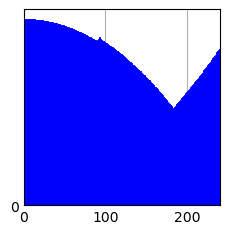

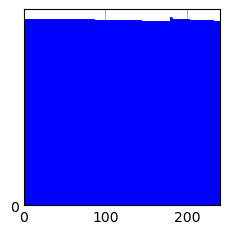

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from random import uniform as uf
from random import randint as ri


class Disco:
    def __init__(self, elradio, lamasa, laposicionx, laposiciony, lavelocidadx, lavelocidady):
        self.radio = elradio
        self.masa = lamasa
        self.posicionx = laposicionx
        self.posiciony = laposiciony
        self.velocidadx = lavelocidadx
        self.velocidady = lavelocidady
        self.color = [0,0,1]
        #posicion de los discos para crear el histograma
        self.arrayposicionx = np.array([])
        self.arrayposiciony = np.array([])
    #Variacion de las fronteras
    #función miembro para obtener el límite derecho
    def right(self):
        return self.posicionx + self.radio

    #función miembro para obtener el límite izquierdo
    def left(self):
        return self.posicionx - self.radio

    #funcion miembro para obtener el límite superior
    def top(self):
        return self.posiciony + self.radio

    #funcion miembro para obtener el límite inferior
    def bottom(self):
        return self.posiciony - self.radio

class Box:
    def __init__(self,lalongitudX,lalongitudY):
      self.longitudx = lalongitudX
      self.longitudy = lalongitudY

class Grilla:
  def __init__(self,xmax,ymax,ldiscos):
    self.xmax = xmax
    self.subdivisionesx = int(xmax/(2*ldiscos[0].radio)) #cantidad de subdivisiones en el eje x
    self.subdivisionesy = int(ymax/(2*ldiscos[0].radio)) #cantidad de subdivisiones en el eje y

    def creacion_grilla(self,xmax,ldiscos):
      #creación de la grilla para detección
      #subdivisionesx = int(xmax/(2*ldiscos[0].radio)) #cantidad de subdivisiones en el eje x
      divisionX = np.linspace(0,xmax,self.subdivisionesx)
      divisionY = np.linspace(0,ymax,self.subdivisionesy)
      dist_entre_separX = divisionX[1]
      return divisionX, dist_entre_separX
    self.divisionX = creacion_grilla(self,xmax,ldiscos)[0]
    self.divisionY = creacion_grilla(self,ymax,ldiscos)[0]
    self.dist_entre_separX = creacion_grilla(self,xmax,ldiscos)[1]


#'controlador'
def nueva_posicion(disco, dt):
    #funcion para una nueva posicion del disco al moverse
    #con la ec. x_f = x_0 + vt
    disco.posicionx += disco.velocidadx * dt
    disco.posiciony += disco.velocidady * dt
    disco.arrayposicionx = np.append(disco.arrayposicionx,disco.posicionx)
    disco.arrayposiciony = np.append(disco.arrayposiciony,disco.posiciony)
    return disco

def deteccion_colision_pared(disco,lx,ly,n,newt):

  #Calculamos el tiempo hasta el próximo fotograma
  tprox = (n+1)*newt

  #Esta parte viene de realizar una parametrización de la trayectoria del disco por medio de la ecuación paramétrica de la recta.
  #Buscamos el tiempo t entre el intervalo de [0,1] en el que se causa la colisión con la pared

  posicioninicial = disco.right()
  posicionfinal = disco.right() + disco.velocidadx*tprox
  if posicionfinal >= lx:
    t = (lx - disco.right())/(posicionfinal - disco.right())
    x = disco.right() + t*(posicionfinal-disco.right())
    disco.posicionx = x - disco.radio
    disco.velocidadx *= -1

  posicioninicial = disco.left()
  posicionfinal = disco.left() + disco.velocidadx*tprox
  if posicionfinal <= 0:
    t = -1*disco.left()/(posicionfinal - disco.left())
    x = disco.left() + t*(posicionfinal-disco.left())
    disco.posicionx = x + disco.radio
    disco.velocidadx *= -1

  posicioninicial = disco.top()
  posicionfinal = disco.top() + disco.velocidady*tprox
  if posicionfinal >= ly:
    t = (ly - disco.top())/(posicionfinal - disco.top())
    y = disco.top() + t*(posicionfinal-disco.top())
    disco.posiciony = y - disco.radio
    disco.velocidady *= -1

  posicioninicial = disco.bottom()
  posicionfinal = posicioninicial + disco.velocidady*tprox
  if posicionfinal <= 0:
    t = -1*disco.bottom()/(posicionfinal - disco.bottom())
    y = disco.bottom() + t*(posicionfinal - disco.bottom())
    disco.posiciony = y + disco.radio
    disco.velocidady *= -1

  return disco


#función para el cambio en la velocidad de los discos que colisionan
def cambio_velocidad_colision_pares(disco1,disco2):

    v1x = (disco1.velocidadx*(disco1.masa - disco2.masa) + 2*disco2.masa*disco2.velocidadx)/(disco1.masa + disco2.masa)
    v1y = (disco1.velocidady*(disco1.masa - disco2.masa) + 2*disco2.masa*disco2.velocidady)/(disco1.masa + disco2.masa)
    v2x = (disco2.velocidadx*(disco2.masa - disco1.masa) + 2*disco1.masa*disco1.velocidadx)/(disco1.masa + disco2.masa)
    v2y = (disco2.velocidady*(disco2.masa - disco1.masa) + 2*disco1.masa*disco1.velocidady)/(disco1.masa + disco2.masa)

    disco1.velocidadx = v1x
    disco1.velocidady = v1y
    disco2.velocidadx = v2x
    disco2.velocidady = v2y

    return disco1, disco2

def deteccion_colision_pares(grilla,ldiscos,cambio_velocidad,n,newt,manejo_colision):

  #verificación de posiciones en un grilla y en sus vecinas inmediatas sobre el eje x
  for j in grilla.divisionX:
    discos_en_grilla = []
    for i in range(len(ldiscos)):
      ##################################################### Ver si el 2*j mejora el rendimiento sin a fectar a la deteccion efectiva #####################################################
      if abs(ldiscos[i].posicionx - j) < (2*grilla.dist_entre_separX):
          discos_en_grilla.append(ldiscos[i])

    #descartamos los discos que no se sobreponen en X
    for i in discos_en_grilla:
      for k in discos_en_grilla:
        if i == k:
          pass
        else:
          dist = np.sqrt(np.square(i.posicionx - k.posicionx) + np.square(i.posiciony - k.posiciony))
          if dist <= i.radio + k.radio:
            i,k = manejo_colision(i,k,cambio_velocidad,n,newt)
  return ldiscos


def sistema_colision_forzada_pares(disc1,disc2,cambio_velocidad,n,newt):
  #Actualización de la posicion para evitar que el sistema fusione los discos
  disc1.posicionx = disc1.arrayposicionx[n-1]
  disc1.posiciony = disc1.arrayposiciony[n-1]
  disc2.posicionx = disc2.arrayposicionx[n-1]
  disc2.posiciony = disc2.arrayposiciony[n-1]
  #Actualización de la velocidad
  disc1,disc2 = cambio_velocidad(disc1,disc2)
  return disc1,disc2


def acomodo_inicial_discos(radio, masa, velMin, velMax, caja, num_discos, color = False): #esta es una función para el caso en el
                                                                            #que se quiera hacer un acomodo de posiciones
                                                                            #para un numero por definir de discos
  def colores():
    colors = [[1,0,0],[0,1,0],[0,0,1],[1,1,0],[1,0,1],[0,1,1],[0,0,0]]
    new_color_number = ri(0,len(colors)-1)
    new_color = colors[new_color_number]
    return new_color

  ldiscos = []
  if num_discos == 1:
    posX = caja.longitudx/2
    posY = caja.longitudy/2
    veloX = uf(velMin, velMax)
    veloY = uf(velMin, velMax)
    ldiscos.append(Disco(radio, masa, posX, posY ,veloX, veloY))


  elif num_discos <= 0:
    print("El numero de discos debe ser mayor a 0.")

  else:
    if type(num_discos) == int:
      if (num_discos/2)%(2) == 0:
        num_subdivisionx = int(num_discos/2)
        num_subdivisiony = num_subdivisionx
        posiciones_x = np.linspace(0.02+radio,caja.longitudx-radio-0.02,num_subdivisionx)
        posiciones_y = np.linspace(0.02+radio,caja.longitudy-radio-0.02,num_subdivisiony)
      else:
        num_subdivisionx = int((num_discos+1)/2)
        num_subdivisiony = int((num_discos-1)/2)
        posiciones_x = np.linspace(radio,caja.longitudx-radio,num_subdivisionx)
        posiciones_y = np.linspace(radio,caja.longitudy-radio,num_subdivisiony)
      contador = 0
      for i in range(num_subdivisionx):
        for j in range(num_subdivisiony):
          posX = posiciones_x[i]
          posY = posiciones_y[j]
          veloX = uf(velMin, velMax)
          veloY = uf(velMin, velMax)
          ldiscos.append(Disco(radio, masa, posiciones_x[i], posiciones_y[j] ,veloX, veloY))
          if color == True:
            ldiscos[contador].color = colores()
          contador += 1

    else:
      print("El numero de discos debe ser un entero")

  return ldiscos


def graf_discos(discos,caja,fotograma,grilla):
  plt.style.use('_mpl-gallery')
  fig, ax = plt.subplots()
  for i in range(len(discos)):
    circ = plt.Circle((discos[i].posicionx, discos[i].posiciony), discos[i].radio,color=discos[i].color)
    ax.add_patch(circ)
  ax.set(xlim=(0, caja.longitudx), xticks=grilla.divisionX,xticklabels="",ylim=(0, caja.longitudy),yticks=grilla.divisionY,yticklabels="")
  #falta guardarlo en una carpeta, por el momento solo es para ver si se grafica bien
  plt.show()
  plt.close()


def histo_discos(discos,tiempos,tmax,newt):
  plt.style.use('_mpl-gallery')

  sizex = tiempos.size
  x = 0.5 + np.arange(sizex)

  for i in discos:
    y = []
    for j in range(len(i.arrayposiciony)):
      y.append(i.arrayposicionx[j])

    fig, ax = plt.subplots()

    ax.bar(x, y, width=1, edgecolor="blue", linewidth=0.7)

    ax.set(xlim=(0, sizex),
           ylim=(0, 1), yticks=np.arange(0, 1))

    plt.show()


def main():
    ################################### Parámetros iniciales del sistema ###################################
    #dimension de la caja
    ladohorizontal = 1
    ladovertical = 1
    caja = Box(ladohorizontal,ladovertical)
    #incializacion de discos
    discos = []
    numero_discos = 6
    masa = 1
    radio = 0.05
    #velomax = 0.005
    velomax = 0.008

    ############## Esta función sirve para inicializar los discos previendo que no se sobrepongan al crearse, y está abierto a cualquier número de discos ##############

    discos = acomodo_inicial_discos(radio, masa, -velomax, velomax, caja, numero_discos, True)

    ############## Este código marcado entre comillas triples es para la inicialización de los discos en posiciones establecidas, pero depende de hacerlo a mano ##############
    ############inicializacion de los discos por medio de unas posicones conocidas pero con velocidades aleatorias##################################

    """posicionX = [0.1, 0.1, 0.9, 0.9]
    posicionY = [0.1, 0.9, 0.1, 0.9]
    velocidadX = [uf(-velomax,velomax),uf(-velomax,velomax),uf(-velomax,velomax),uf(-velomax,velomax)]
    velocidadY = [uf(-velomax,velomax),uf(-velomax,velomax),uf(-velomax,velomax),uf(-velomax,velomax)]
    for i in range(numero_discos):
      discos.append(Disco(radio, masa, posicionX[i], posicionY[i] ,velocidadX[i], velocidadY[i]))"""
    ################################################################################################################################################
    ########## Creacion del objeto grilla para la detección de colisiones ##########
    grilla = Grilla(caja.longitudx,caja.longitudy,discos)

    #evolucion temporal
    FPS = 60
    newt = 1/FPS
    tmax = 4
    tprima = 0
    timearray = np.zeros(tmax*FPS)
    for n in range(0,tmax*FPS):
      #actualizacion de posiciones
      #tprima es el tiempo actual del sistema
      tprima = n*newt
      timearray[n] = tprima
      #actualizacion de las posiciones de los discos
      for i in range(numero_discos):
        discos[i] = nueva_posicion(discos[i],tprima)
        #verificación de colisiones con las paredes
        discos[i] = deteccion_colision_pared(discos[i],caja.longitudx,caja.longitudy,n,newt)
      #verificacion de colisiones entre los discos
      discos = deteccion_colision_pares(grilla,discos,cambio_velocidad_colision_pares,n,newt,sistema_colision_forzada_pares)
      graf_discos(discos,caja,0,grilla)
    histo_discos(discos,timearray,tmax,newt)


main()